In [1]:
import numpy as np
import matplotlib.pyplot as plt

from blog_utils import *

## Method signatures
* dense_pairwise_distances(points)  Computes dense pairwise distance matrix on points
* cross_dist(points, targets)  Computes Euclidean distance between point_i and every target in targets_i as an i,k matrix
* get_top_nn(points, k)  Gets the indices of the top-K nearest neighbors of every point in points
* embed_in_high_dim(points, embed_dim)  linearly embeds low-d manifold into higher dimensional space

### embedding methods
* make_tsne_embedding(points)
* make_mds_embedding(points)
* make_pca_embedding(points)

### embedding distance methods
* nn_cos_sim_distance(points_a, points_b, num_nn)
* iou_distance(points_a, points_b, num_nn)

### sampling methods
* sample_sphere(manifold_dim, num_points, snr)  samples from n-dimensional spherical surface
* sample_hypercube(manifold_dim, num_points, snr)  samples from n-dimensional hypercube surface, avoiding exact corners
* sample_torus(num_points, snr, tube_radius, outer_radius)  samples from 3-d torus  (adapt to n-d somehow?????)

def helper_triple_plot(manifold_dim, embedding_dim, embed_type, *, num_nn=15, snr=10, num_points=2000):
    point_groups = [
        sample_sphere(manifold_dim, num_points, snr),
        sample_hypercube(manifold_dim, num_points, snr),
    ]
    manifold_names = ['sphere', 'cube']
    if manifold_dim == 3:
        point_groups.append(sample_torus(num_points, snr, 1, 3))
        manifold_names.append('torus')
    
    point_groups = [embed_in_high_dim(pcloud, embedding_dim) for pcloud in point_groups]
    
    if embed_type == 'pca':
        embeddings = [make_pca_embedding(pcloud) for pcloud in point_groups]
    elif embed_type == 'tsne':
        embeddings = [make_tsne_embedding(pcloud) for pcloud in point_groups]
    else:
        embeddings = [make_mds_embedding(pcloud) for pcloud in point_groups]
    
    for points, embed_points, mname in zip(point_groups, embeddings, manifold_names):
        points = (points - points.mean()) / points.var()
        
        fig_title = f'{manifold_dim}-d {mname.capitalize()} Embedded in {embedding_dim}-d Space.'
        fname = fig_title.replace('-', '_').replace(' ', '_')
        
        helper_plot_err(points, embed_points, embed_type, fig_title, fname, num_nn=num_nn)


nonuniform_pmf = (0.07
    + make_gaussian([0.65, 0.75], 0.05, 200)
    + make_gaussian([0.25, 0.55], [0.10, 0.07], 200)
    + make_gaussian([0.85, 0.15], [0.05, 0.2], 200)
)
nonuniform_pmf /= nonuniform_pmf.sum()

nonuniform_sample = sample_cloth(2000, nonuniform_pmf)
uniform_sample = sample_cloth(2000)

nonuniform_sample = embed_in_high_dim(nonuniform_sample, 10)
uniform_sample = embed_in_high_dim(uniform_sample, 10)

umaps_uniform = {}
for n in (2, 5, 10, 20, 50, 100, 200):
    for min_dist in (0.0, 0.1, 0.25, 0.5, 0.65, 0.8, 0.99):
        umaps_uniform[f'{n}_{min_dist:.2f}'] = make_umap_embedding(uniform_sample, n_neighbors=n, min_dist=min_dist)

umaps_nonuniform = {}
for n in (2, 5, 10, 20, 50, 100, 200):
    for min_dist in (0.0, 0.1, 0.25, 0.5, 0.65, 0.8, 0.99):
        umaps_nonuniform[f'{n}_{min_dist:.2f}'] = make_umap_embedding(nonuniform_sample, n_neighbors=n, min_dist=min_dist)

for k, v in umaps_uniform.items():
    np.save(f'uniform_cloth_umaps/{k}.npy', v)
for k, v in umaps_nonuniform.items():
    np.save(f'nonuniform_cloth_umaps/{k}.npy', v)

tsnes_uniform = {}
for p in (5, 10, 15, 20, 25, 35, 40, 45, 50):
    for ee in np.linspace(6, 42, 7, endpoint=True):
        tsnes_uniform[f'{p}_{ee:.1f}'] = make_tsne_embedding(uniform_sample, perplexity=p, early_exaggeration=ee)

tsnes_nonuniform = {}
for p in (5, 10, 15, 20, 25, 35, 40, 45, 50):
    for ee in np.linspace(6, 42, 7, endpoint=True):
        tsnes_nonuniform[f'{p}_{ee:.1f}'] = make_tsne_embedding(nonuniform_sample, perplexity=p, early_exaggeration=ee)

for k, v in tsnes_uniform.items():
    np.save(f'uniform_cloth_tsnes/{k}.npy', v)
for k, v in tsnes_nonuniform.items():
    np.save(f'nonuniform_cloth_tsnes/{k}.npy', v)

num_neighbors_sweep = (2, 5, 10, 20, 50, 100, 200)
min_dist_sweep = (0.0, 0.1, 0.25, 0.5, 0.65, 0.8, 0.99)
get_fname = lambda n,d: f'uniform_cloth_umaps/{n}_{d:.2f}.npy'

uniform_samples = np.load('cloth_images/uniform_sample.npy')
num_nn = 15

fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(7, 7, wspace=0, hspace=0, left=0.05, bottom=0.05, top=0.95, right=1)

# fake axis labels and title
fig.text(0.5, 0.975, 'Uniformly Sampled Cloth UMAP Embeddings', horizontalalignment='center', fontsize=24)
fig.text(0.5, 0.01, 'Num. Neighbors', wrap=True, horizontalalignment='center', fontsize=18)
fig.text(0.01, 0.5, 'Min. Dist', wrap=True, horizontalalignment='center', fontsize=18, rotation=90)

for i, min_dist in enumerate(min_dist_sweep):
    for j, num_neighbors in enumerate(num_neighbors_sweep):
        # num neighbors along x axis, min dist along y axis
        # ax = fig.add_subplot(7, 7, i*7+j+1)
        ax = fig.add_subplot(gs[i,j])
        data = np.load(get_fname(num_neighbors, min_dist))
        errs = iou_distance(uniform_samples, data, num_nn=num_nn)
        scatter = ax.scatter(data[:, 0], data[:, 1], c=errs, cmap='magma_r', s=2)
        scatter.set_clim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == len(min_dist_sweep) - 1:
            ax.set_xlabel(f'{num_neighbors}')  # label j
        if j == 0:
            ax.set_ylabel(f'{min_dist:.2f}', rotation=0, horizontalalignment='right')  # label i
        ax.label_outer()
plt.show()

num_neighbors_sweep = (2, 5, 10, 20, 50, 100, 200)
min_dist_sweep = (0.0, 0.1, 0.25, 0.5, 0.65, 0.8, 0.99)
get_fname = lambda n,d: f'nonuniform_cloth_umaps/{n}_{d:.2f}.npy'

nonuniform_samples = np.load('cloth_images/nonuniform_sample.npy')
num_nn = 15

fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(7, 7, wspace=0, hspace=0, left=0.05, bottom=0.05, top=0.95, right=1)

# fake axis labels and title
fig.text(0.5, 0.975, 'Non-uniformly Sampled Cloth UMAP Embeddings', horizontalalignment='center', fontsize=24)
fig.text(0.5, 0.01, 'Num. Neighbors', wrap=True, horizontalalignment='center', fontsize=18)
fig.text(0.01, 0.5, 'Min. Dist', wrap=True, horizontalalignment='center', fontsize=18, rotation=90)

for i, min_dist in enumerate(min_dist_sweep):
    for j, num_neighbors in enumerate(num_neighbors_sweep):
        # num neighbors along x axis, min dist along y axis
        # ax = fig.add_subplot(7, 7, i*7+j+1)
        ax = fig.add_subplot(gs[i,j])
        data = np.load(get_fname(num_neighbors, min_dist))
        errs = iou_distance(nonuniform_samples, data, num_nn=num_nn)
        scatter = ax.scatter(data[:, 0], data[:, 1], c=errs, cmap='magma_r', s=2)
        scatter.set_clim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == len(min_dist_sweep) - 1:
            ax.set_xlabel(f'{num_neighbors}')  # label j
        if j == 0:
            ax.set_ylabel(f'{min_dist:.2f}', rotation=0, horizontalalignment='right')  # label i
        ax.label_outer()
plt.show()

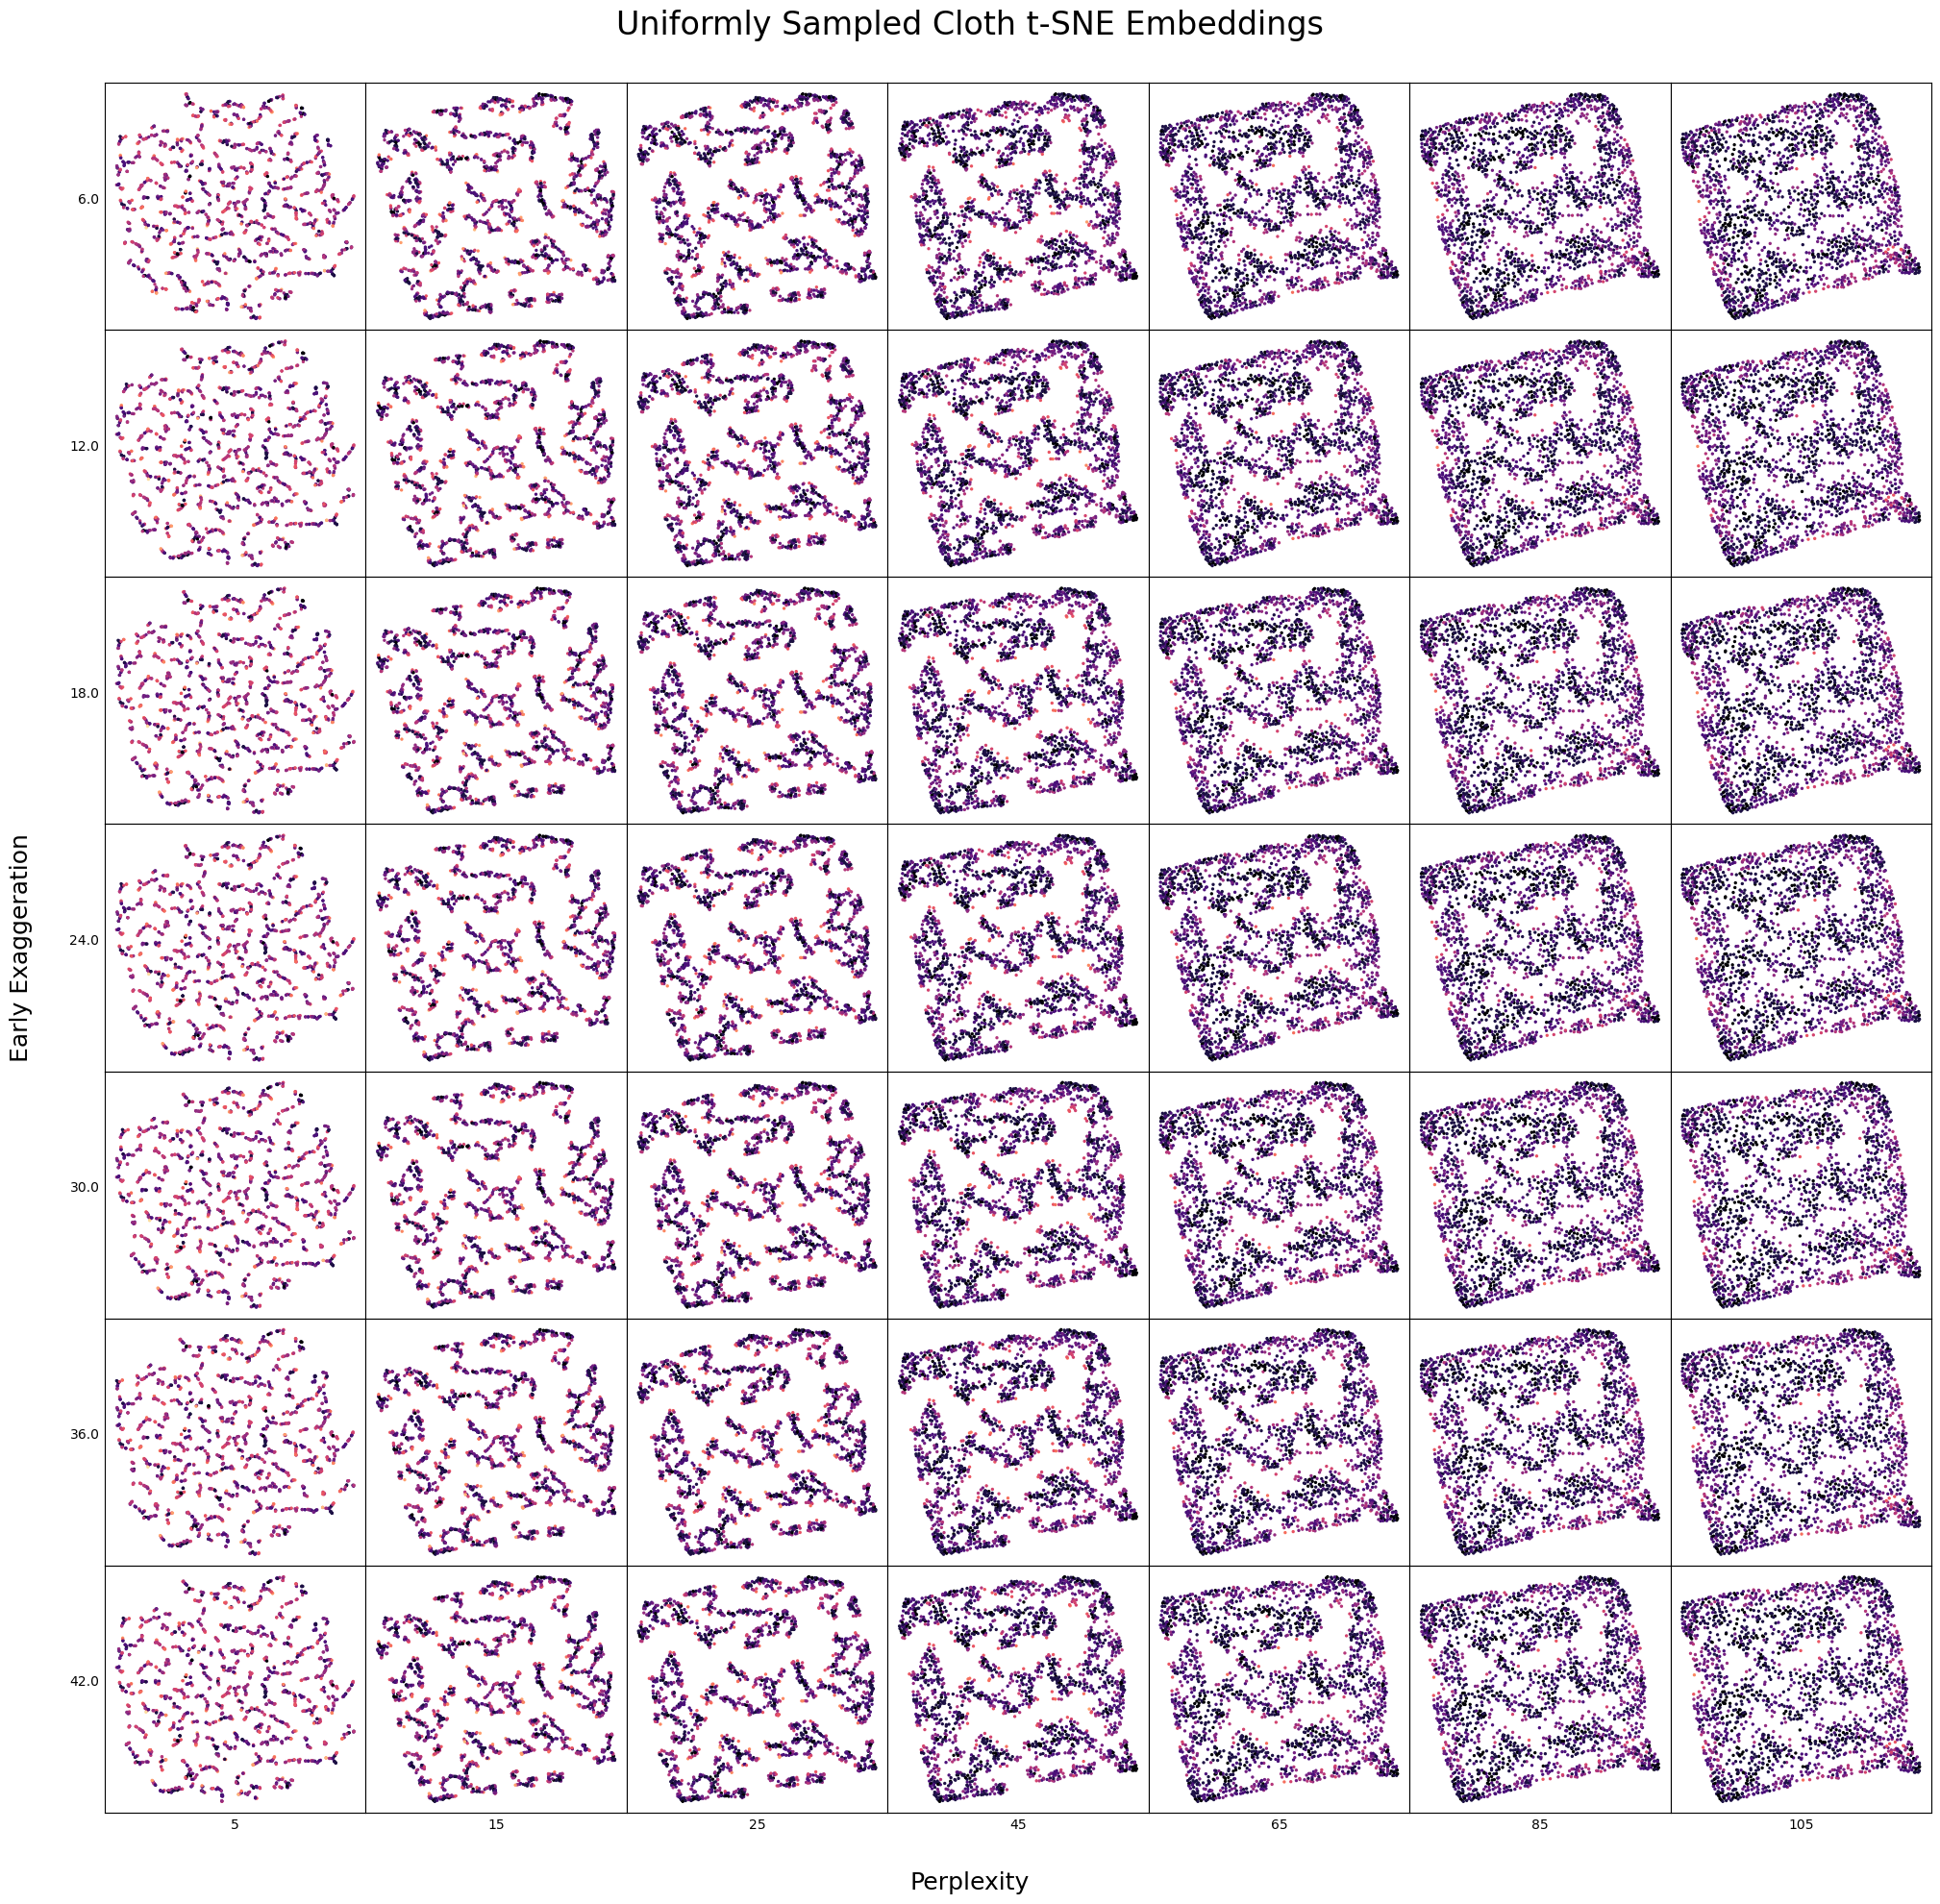

In [36]:
perplexity_sweep = (5, 15, 25, 45, 65, 85, 105)
early_exagg_sweep = np.linspace(6, 42, 7, endpoint=True)
get_fname = lambda p,ee: f'uniform_cloth_tsnes/{p}_{ee:.1f}.npy'

uniform_samples = np.load('cloth_images/uniform_sample.npy')
num_nn = 15

fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(7, 7, wspace=0, hspace=0, left=0.05, bottom=0.05, top=0.95, right=1)

# fake axis labels and title
fig.text(0.5, 0.975, 'Uniformly Sampled Cloth t-SNE Embeddings', horizontalalignment='center', fontsize=24)
fig.text(0.5, 0.01, 'Perplexity', wrap=True, horizontalalignment='center', fontsize=18)
fig.text(0.01, 0.5, 'Early Exaggeration', wrap=True, horizontalalignment='center', fontsize=18, rotation=90)

for i, early_exagg in enumerate(early_exagg_sweep):
    for j, perplexity in enumerate(perplexity_sweep):
        # num neighbors along x axis, min dist along y axis
        # ax = fig.add_subplot(7, 7, i*7+j+1)
        ax = fig.add_subplot(gs[i,j])
        data = np.load(get_fname(perplexity, early_exagg))
        errs = iou_distance(uniform_samples, data, num_nn=num_nn)
        scatter = ax.scatter(data[:, 0], data[:, 1], c=errs, cmap='magma_r', s=2)
        scatter.set_clim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == len(early_exagg_sweep) - 1:
            ax.set_xlabel(f'{perplexity}')  # label j
        if j == 0:
            ax.set_ylabel(f'{early_exagg:.1f}', rotation=0, horizontalalignment='right')  # label i
        ax.label_outer()
plt.show()

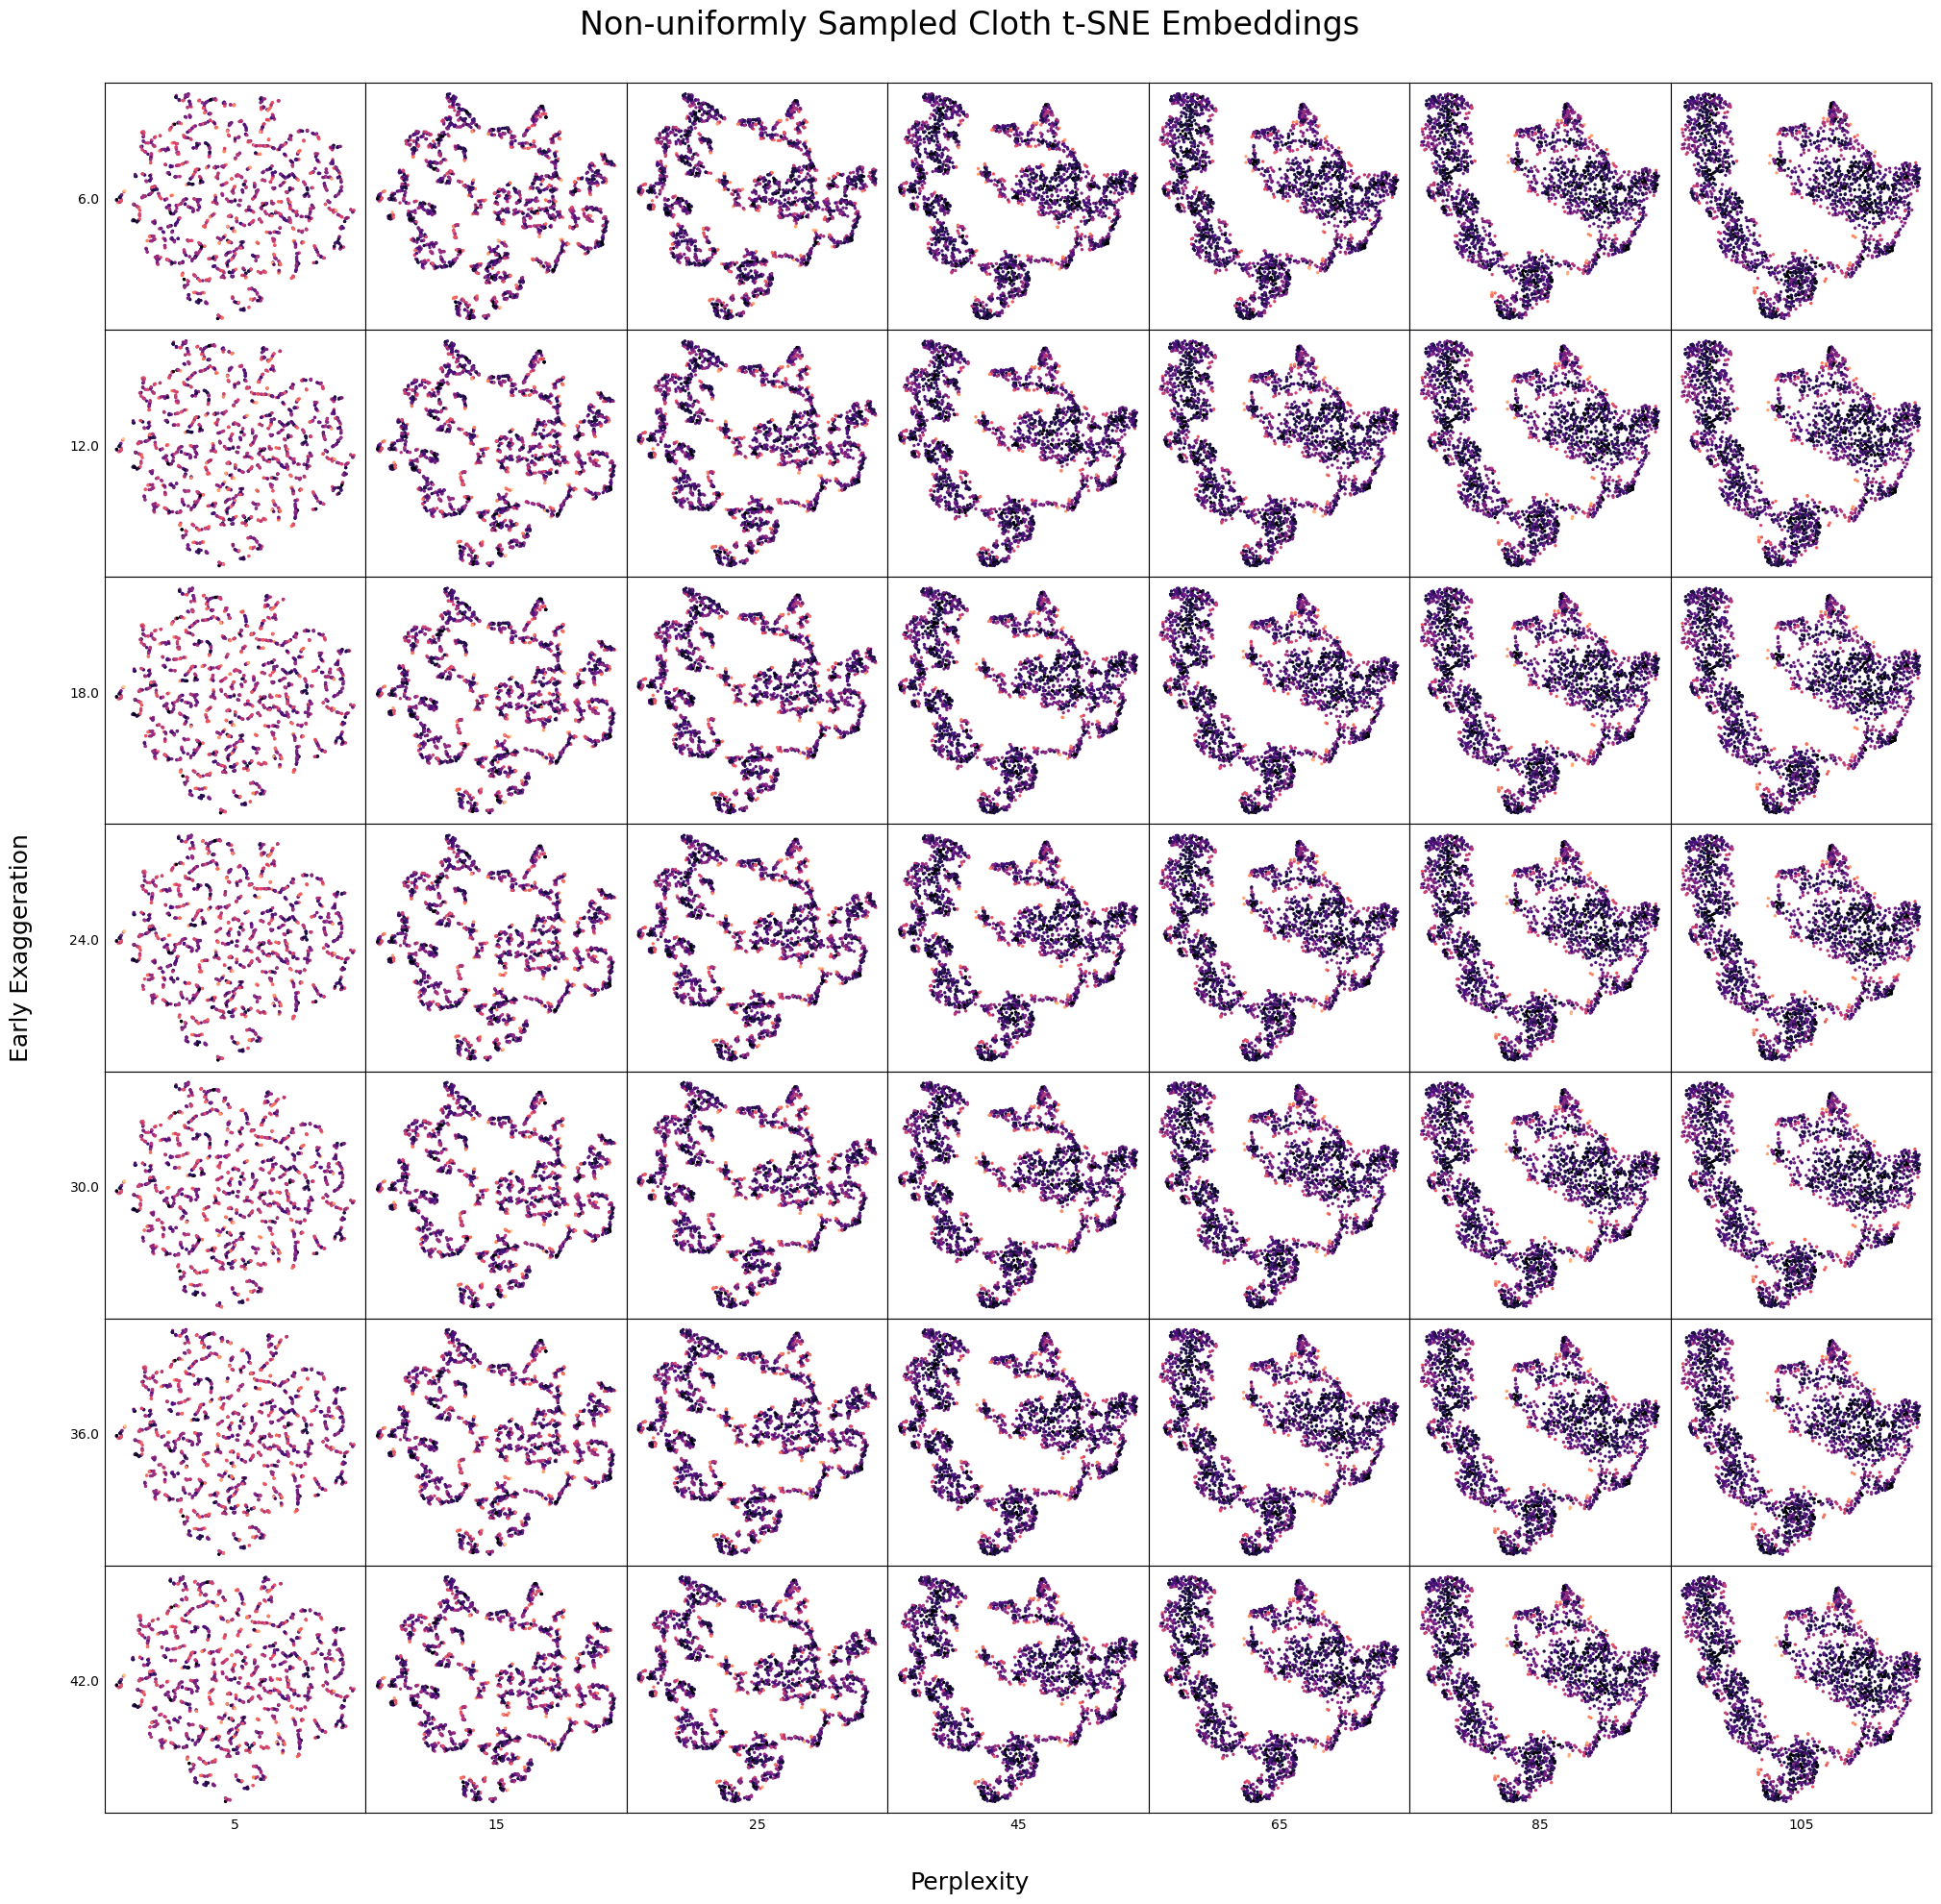

In [ ]:
perplexity_sweep = (5, 15, 25, 45, 65, 85, 105)
early_exagg_sweep = np.linspace(6, 42, 7, endpoint=True)
get_fname = lambda p,ee: f'nonuniform_cloth_tsnes/{p}_{ee:.1f}.npy'

nonuniform_samples = np.load('cloth_images/nonuniform_sample.npy')
num_nn = 15

fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(7, 7, wspace=0, hspace=0, left=0.05, bottom=0.05, top=0.95, right=1)

# fake axis labels and title
fig.text(0.5, 0.975, 'Non-uniformly Sampled Cloth t-SNE Embeddings', horizontalalignment='center', fontsize=24)
fig.text(0.5, 0.01, 'Perplexity', wrap=True, horizontalalignment='center', fontsize=18)
fig.text(0.01, 0.5, 'Early Exaggeration', wrap=True, horizontalalignment='center', fontsize=18, rotation=90)

for i, early_exagg in enumerate(early_exagg_sweep):
    for j, perplexity in enumerate(perplexity_sweep):
        # num neighbors along x axis, min dist along y axis
        # ax = fig.add_subplot(7, 7, i*7+j+1)
        ax = fig.add_subplot(gs[i,j])
        data = np.load(get_fname(perplexity, early_exagg))
        errs = iou_distance(nonuniform_samples, data, num_nn=num_nn)
        scatter = ax.scatter(data[:, 0], data[:, 1], c=errs, cmap='magma_r', s=2)
        scatter.set_clim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == len(early_exagg_sweep) - 1:
            ax.set_xlabel(f'{perplexity}')  # label j
        if j == 0:
            ax.set_ylabel(f'{early_exagg:.1f}', rotation=0, horizontalalignment='right')  # label i
        ax.label_outer()
plt.show()